In [18]:
import pandas as pd 

## NLP Scores 

In [16]:
df = pd.read_csv("current_scores.csv")
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'].notna()]

df = df.sort_values('date')

base_cols = ['employment_level', 'employment_dynamics',	'inflation_level', 'inflation_dynamics', 'interest_rate_trajectory', 'balance_sheet_trajectory', 'forward_guidance_guidance']


max_lags = 3

### Create ordinary diffs
for col in base_cols:
    for lag in range(1, max_lags + 1):
        df[f'{col}_ord_diff_{lag}'] = df[f'{col}_score'].diff(lag)


### Create pct_diffs 
for col in base_cols:
    for lag in range(1, max_lags+1):
        df[f'{col}_pct_diff_{lag}'] = df[f'{col}_score'].pct_change(periods=lag, fill_method=None)


## Compute diff * level_t-1
for col in base_cols:
    for lag in range(1, max_lags + 1):
        df[f'{col}_diff_mult_level_{lag}'] = df[f'{col}_score'].diff(lag) * df[f'{col}_score'].shift(lag)

## Compute cross differences (diff level * diff dynamics)
for lag in range(1, max_lags+1):
    df[f'employment_cross_diff'] = df[f'employment_level_score'].diff(lag) * df[f'employment_dynamics_score'].diff(lag)
    df['inflation_cross_diff'] = df[f'inflation_level_score'].diff(lag) * df[f'inflation_dynamics_score'].diff(lag)




## Data From FRED (+S&P500 from Yahoo)

In [20]:
market_data = pd.read_csv("/Users/dzz1th/Job/mgi/Soroka/data/pc_data/us_market_data.csv")
market_data.columns = ['date', 'SP500', 'VIX', 'USD_BROAD', 'USD_MAJOR', 'HY_SPREAD']
market_data['date'] = pd.to_datetime(market_data['date'])


tips_data = pd.read_csv("/Users/dzz1th/Job/mgi/Soroka/data/pc_data/us_tips_data.csv")
tips_data.columns = ['date', 'TIPS_5Y', 'TIPS_10Y', 'TIPS_20Y', 'TIPS_30Y']
tips_data['date'] = pd.to_datetime(tips_data['date'])

yields_data = pd.read_csv("/Users/dzz1th/Job/mgi/Soroka/data/pc_data/us_yields.csv")
yields_data.columns = ['date', '1M', '3M', '6M', '1Y', '2Y', '5Y', '10Y', '30Y']
yields_data['date'] = pd.to_datetime(yields_data['date'])


targets_data = pd.merge(market_data, tips_data, on='date', how='inner')
targets_data = pd.merge(targets_data, yields_data, on='date', how='inner')


# # For each date, we compute change from previous day to the close of the current day

targets_data['Inflation_5Y'] = targets_data['5Y'] - targets_data['TIPS_5Y']
targets_data['Inflation_10Y'] = targets_data['10Y'] - targets_data['TIPS_10Y']
targets_data['Inflation_30Y'] = targets_data['30Y'] - targets_data['TIPS_30Y']

for col in targets_data.columns:
    if col not in ['date']:
        if col in ['SP500', 'VIX', 'USD_BROAD', 'USD_MAJOR']:
            targets_data[col] = targets_data[col].pct_change() * 100
        else:
            targets_data[col] = targets_data[col].diff()




targets_data.dropna(inplace=True)
targets_data.tail()


,date,SP500,VIX,USD_BROAD,USD_MAJOR,HY_SPREAD,TIPS_5Y,TIPS_10Y,TIPS_20Y,TIPS_30Y,...,3M,6M,1Y,2Y,5Y,10Y,30Y,Inflation_5Y,Inflation_10Y,Inflation_30Y
3683,2025-02-13,1.042629,-4.971680,-0.350107,0.0,0.00,-0.07,-0.08,-0.08,-0.08,...,-0.01,0.00,-0.03,-0.05,-0.09,-0.10,-0.11,-0.02,-2.000000e-02,-3.000000e-02
3684,2025-02-14,-0.007194,-2.185430,-0.571196,0.0,-0.03,-0.04,-0.04,-0.03,-0.02,...,0.00,-0.01,-0.04,-0.05,-0.06,-0.05,-0.03,-0.02,-1.000000e-02,-1.000000e-02
3685,2025-02-17,0.000000,4.062288,0.000000,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00
3686,2025-02-18,0.244499,-0.130124,0.118178,0.0,0.00,0.04,0.06,0.06,0.05,...,0.00,0.02,0.01,0.03,0.07,0.08,0.08,0.03,2.000000e-02,3.000000e-02
3687,2025-02-19,0.000000,-0.521173,0.329174,0.0,0.06,-0.04,-0.02,-0.01,-0.01,...,0.00,0.00,-0.02,-0.01,-0.03,-0.02,-0.01,0.01,4.440892e-16,4.440892e-16


## Data from Ivan (with forwards/spreads)



In [83]:
excel_file = "DataForOlehV2.xlsx"
long_history = pd.read_excel(
    excel_file,
    sheet_name="Long History", # 0-based index
    nrows=442
)

long_history.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
long_history['date'] = pd.to_datetime(long_history['date'])

long_history.head()
df0 = long_history[long_history['Meeting Date'] == -1]
df1 = long_history[long_history['Meeting Date'] == 1]

df0['date'] = df0['date'] + pd.Timedelta(days=1)
df1['date'] = df1['date'] - pd.Timedelta(days=1)
df1.columns = [f'{col}_end' if col not in ['Meeting Date', 'date'] else col for col in df1.columns]
result_df = pd.merge(df0, df1, on='date', how='inner')

for col in df0.columns:
    if col not in ['Meeting Date', 'date']:
        result_df[f'{col}_diff'] = result_df[f'{col}_end'] - result_df[col]

# Changes in variables associated with the meeting, close of day before and close of day of the meeting
filter_cols = ['date'] + [f'{col}_diff' for col in df0.columns if col not in ['Meeting Date', 'date']]
rates_df = result_df[filter_cols]


/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_91691/1742576648.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df0['date'] = df0['date'] + pd.Timedelta(days=1)
/var/folders/bg/7dlg6wfn7l1cn6q3xxnwfj_80000gn/T/ipykernel_91691/1742576648.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['date'] = df1['date'] - pd.Timedelta(days=1)


## Data with Monetary Surprises (From SF FED)

In [21]:
sheet_name = "FOMC (update 2023)"
excel_file = "monetary-policy-surprises-data.xlsx"

monetary_surprises_df = pd.read_excel(
    excel_file,
    sheet_name=sheet_name, # 0-based index
    nrows=362
)


monetary_surprises_df['Date'] = pd.to_datetime(monetary_surprises_df['Date'])
monetary_surprises_df = monetary_surprises_df[monetary_surprises_df['Date'] >= df['date'].min()]
monetary_surprises_df = monetary_surprises_df[monetary_surprises_df['Date'] <= df['date'].max()]
monetary_surprises_df = monetary_surprises_df[['Date', 'MPS', 'MPS_ORTH']]
monetary_surprises_df.rename(columns={'Date': 'date'}, inplace=True)

## Resulting Dataset for the analysis

In [22]:
# data on monetary surprises from 2011 to 2023
regression_df = pd.merge(df, monetary_surprises_df, on='date', how='inner')

regression_df = pd.merge(regression_df, targets_data, on='date', how='inner')

target_cols = [col for col in targets_data.columns if col != 'date']

regression_df[target_cols]

,SP500,VIX,USD_BROAD,USD_MAJOR,HY_SPREAD,TIPS_5Y,TIPS_10Y,TIPS_20Y,TIPS_30Y,1M,3M,6M,1Y,2Y,5Y,10Y,30Y,Inflation_5Y,Inflation_10Y,Inflation_30Y
0,0.624985,-1.728553,-0.006608,0.134679,-0.04,-0.04,0.05,0.07,0.05,0.01,-0.01,0.00,0.00,0.00,0.01,0.05,0.06,5.000000e-02,0.00,0.01
1,-0.646845,-1.802757,-0.057911,-0.015270,-0.03,0.02,0.04,0.04,0.03,0.00,-0.01,-0.01,-0.02,-0.01,0.01,0.02,0.01,-1.000000e-02,-0.02,-0.02
2,1.610467,-5.838366,-0.535217,-0.697103,-0.07,-0.10,-0.03,-0.01,0.01,0.00,0.00,-0.01,-0.02,0.00,-0.01,0.02,0.04,9.000000e-02,0.05,0.03
3,0.867914,-3.172924,0.105285,0.246985,0.01,-0.13,-0.11,-0.09,-0.06,0.01,0.00,0.00,0.00,-0.02,-0.11,-0.07,-0.02,2.000000e-02,0.04,0.04
4,1.364459,-7.071823,-0.065297,-0.099804,-0.09,-0.01,0.01,0.03,0.01,0.01,0.00,0.00,0.00,-0.01,0.00,0.01,0.03,1.000000e-02,0.00,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.081943,-4.996578,-0.334410,0.000000,0.00,0.02,-0.02,-0.03,-0.03,-0.01,0.00,0.00,0.01,0.07,0.05,-0.01,-0.04,3.000000e-02,0.01,-0.01
68,-0.015544,-4.834055,-0.074536,0.000000,0.07,-0.04,-0.02,-0.01,0.00,0.00,0.00,-0.02,-0.01,-0.03,-0.06,-0.05,-0.01,-2.000000e-02,-0.03,-0.01
69,-0.939479,7.299787,-0.162528,0.000000,-0.05,0.04,0.00,-0.01,-0.02,0.00,0.02,0.00,0.02,0.04,0.01,-0.02,-0.03,-3.000000e-02,-0.02,-0.01
70,1.050600,-7.001103,-0.034482,0.000000,0.05,-0.11,-0.10,-0.08,-0.07,0.00,-0.02,-0.03,-0.07,-0.12,-0.15,-0.11,-0.08,-4.000000e-02,-0.01,-0.01


<Axes: >

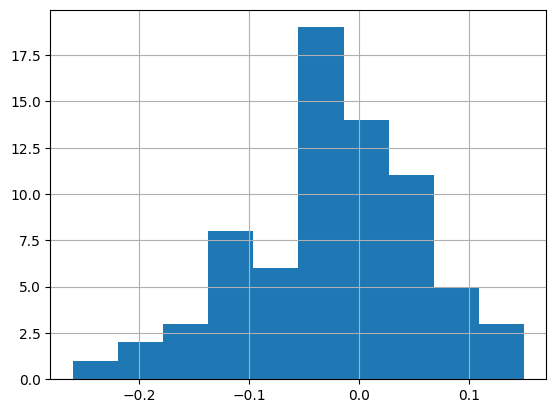

In [6]:
regression_df['TIPS_10Y'].hist()

In [29]:
import statsmodels.api as sm
import typing as t

# target_cols = ['1y', '2y', '5y', '7y', '10y', '30y', '1y1y',
#         '2y1y', '3y1y', '3y2y', '5y2y', '5y5y', '10y5y', '10y10y', '15y5y',
#         '20y10y', '2s5s', '1y2s5s', '5s10s', '1y5s10s', '10s30s', '2y1y/3y2y',
#         '3y2y/5y2y', '5y2y/7y3y', '5y5y/10y10y', '10y10y/20y10y']

# target_cols = [col + '_diff' for col in target_cols]




score_diff_cols = [col for col in regression_df.columns if 'ord_diff_1' in col ]
base_cols = ['employment_level_score', 'employment_dynamics_score',	'inflation_level_score', 'inflation_dynamics_score', 'interest_rate_trajectory_score', 'balance_sheet_trajectory_score', 'forward_guidance_guidance_score']
base_cols += ['MPS']
#base_cols = score_diff_cols + ['MPS']

def fit_OLS(target_col, 
            truncate_X: bool,
            period_start: str = '2012-01-01',
            period_end: str = '2018-01-01'):
    
    train_df = regression_df[(regression_df['date'] >= period_start) & (regression_df['date'] <= period_end)]
    train_df = train_df.dropna(subset=base_cols)
    X = train_df[base_cols]

    if truncate_X:
        X = X.apply(lambda x: x.where(abs(x) >= 0.01, 0))
    
    y = train_df[target_col]
    model = sm.OLS(y, X).fit(cov_type="HC2")

    return {
        'dates': train_df['date'],
        'residuals': model.resid,
        'r2': model.rsquared,
        'adj_r2': model.rsquared_adj,
        'significant_features': [
              (feat, coef, pval) 
              for feat, coef, pval in zip(model.params.index, model.params, model.pvalues) if pval < 0.05
              ]
    }



results = {}
for target_col in target_cols:
    results[target_col] = fit_OLS(target_col, truncate_X=False)

# Print results in a readable format
for rate_col, res in results.items():
    print(f"\nResults for {rate_col}:")
    print(f"R-squared: {res['r2']:.3f}")
    print(f"Adjusted R-squared: {res['adj_r2']:.3f}")
    print("Significant features (p < 0.05):")
    for feat, coef, pval in res['significant_features']:
        print(f"  {feat}: coef = {coef:.4f} (p = {pval:.4f})")
    print("-" * 50)

# Optional: Create a summary DataFrame
summary_df = pd.DataFrame({
    'rate': [k for k in results.keys()],
    'r2': [v['r2'] for v in results.values()],
    'adj_r2': [v['adj_r2'] for v in results.values()],
    'num_significant': [len(v['significant_features']) for v in results.values()]
})

print("\nSummary of all models:")
print(summary_df.sort_values('adj_r2', ascending=False))



Results for SP500:
R-squared: 0.603
Adjusted R-squared: 0.417
Significant features (p < 0.05):
  inflation_dynamics_score: coef = 23.5550 (p = 0.0006)
  MPS: coef = -9.0273 (p = 0.0092)
--------------------------------------------------

Results for VIX:
R-squared: 0.668
Adjusted R-squared: 0.511
Significant features (p < 0.05):
  employment_dynamics_score: coef = -94.5624 (p = 0.0289)
  forward_guidance_guidance_score: coef = 193.5964 (p = 0.0263)
  MPS: coef = 66.6089 (p = 0.0124)
--------------------------------------------------

Results for USD_BROAD:
R-squared: 0.163
Adjusted R-squared: -0.231
Significant features (p < 0.05):
--------------------------------------------------

Results for USD_MAJOR:
R-squared: 0.243
Adjusted R-squared: -0.114
Significant features (p < 0.05):
--------------------------------------------------

Results for HY_SPREAD:
R-squared: 0.429
Adjusted R-squared: 0.160
Significant features (p < 0.05):
  employment_level_score: coef = 0.9127 (p = 0.0121)
  M

In [8]:
from utils import StructuralBreakTester, batch_structural_break_analysis

results, summary = batch_structural_break_analysis(
    data=regression_df,
    target_cols=target_cols, 
    predictor_cols=base_cols,
    date_col='date',
    known_break_dates=['2015-12-16', '2018-06-13', '2020-03-15'],
    save_plots=True
)

Analyzing SP500...
Analyzing VIX...
Analyzing USD_BROAD...
Analyzing USD_MAJOR...
Analyzing HY_SPREAD...
Analyzing TIPS_5Y...
Analyzing TIPS_10Y...
Analyzing TIPS_20Y...
Analyzing TIPS_30Y...
Analyzing 1M...
Analyzing 3M...
Analyzing 6M...
Analyzing 1Y...
Analyzing 2Y...
Analyzing 5Y...
Analyzing 10Y...
Analyzing 30Y...
Analyzing Inflation_5Y...
Analyzing Inflation_10Y...
Analyzing Inflation_30Y...


In [11]:
summary


,target,n_obs,r2,CUSUM (Recursive)_break_5%,Quandt-Andrews_break_5%,Harvey-Collier_break_5%,Harvey-Collier_pval
0,SP500,71,0.039596,True,False,False,NaN
1,VIX,71,0.038798,True,False,False,NaN
2,USD_BROAD,71,0.088760,True,False,False,NaN
3,USD_MAJOR,71,0.106017,False,False,False,NaN
4,HY_SPREAD,71,0.177886,True,False,False,NaN
5,TIPS_5Y,71,0.238818,True,False,False,NaN
6,TIPS_10Y,71,0.201052,True,False,False,NaN
7,TIPS_20Y,71,0.156637,True,False,False,NaN
8,TIPS_30Y,71,0.146294,True,False,False,NaN
9,1M,71,0.234122,True,False,False,NaN
